# Deep Reinforcement Learning on Snake
<hr>

Author: [Sahil Johari](http://www.sahiljohari.com/)

## Problem Statement

_Need to write this_

TO-DO:
* Configurable fps for output
* Code commenting and clean-up
* Display score for each game -- **Done**
* Add graphs to visualize performance of model
* Results evaluation
* Parallelize model for GPU
* Add stopping condition while testing -- **Need a good one**

In [ ]:
from collections import namedtuple
import itertools as it
import os
from random import sample as rsample
import time

import numpy as np

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD, RMSprop, Adam

from matplotlib import pyplot as plt
from IPython.display import display, clear_output

## Creating the game

In [ ]:
class Snake(object):
    def __init__(self, rewards, grid_size):
        self.grid_size = grid_size
        self.snake_length = 3
        self.Fruit = namedtuple('Fruit', ['x', 'y'])
        self.life_reward = rewards[0]
        self.alive_reward = rewards[1]
        self.death_reward = rewards[2]
        self.reset()
        
    def reset(self):
        self.actions = [(-1, 0)] * self.snake_length  # An action for each snake segment
        self.head_x = self.grid_size // 2 - self.snake_length // 2
        self.snake = [(x, self.grid_size // 2) for x in range(self.head_x, self.head_x + self.snake_length)]
        self.grow = -1  # Don't start growing snake yet
        self.fruit = self.Fruit(-1, -1)
        
    def play(self):
        self.reset()
        while True:
            # Draw borders
            screen = np.zeros((self.grid_size, self.grid_size))
            screen[[0, -1]] = 1
            screen[:, [0, -1]] = 1
            sum_of_borders = screen.sum()

            # Draw snake
            for segm in self.snake:
                x, y = segm
                screen[y, x] = 1

            # Snake hit into wall or ate itself
            end_of_game = len(self.snake) > len(set(self.snake)) or screen.sum() < sum_of_borders + len(self.snake)
            reward = self.death_reward * end_of_game if end_of_game else self.alive_reward

            # Draw fruit
            if screen[self.fruit.y, self.fruit.x] > .5:
                self.grow += 1
                reward = len(self.snake) * self.life_reward
                while True:
                    self.fruit = self.Fruit(*np.random.randint(1, self.grid_size - 1, 2))
                    if screen[self.fruit.y, self.fruit.x] < 1:
                        break

            screen[self.fruit.y, self.fruit.x] = .5

            action = yield screen, reward, len(self.snake)-self.snake_length

            step_size = sum([abs(act) for act in action])
            if not step_size:
                action = self.actions[0]  # Repeat last action
            elif step_size > 1:
                raise ValueError('Cannot move more than 1 unit at a time')

            self.actions.insert(0, action)
            self.actions.pop()

            # For as long as the snake needs to grow,
            # copy last segment, and add (0, 0) action
            if self.grow > 0:
                self.snake.append(self.snake[-1])
                self.actions.append((0, 0))
                self.grow -= 1

            # Update snake segments
            for ix, act in enumerate(self.actions):
                x, y = self.snake[ix]
                delta_x, delta_y = act
                self.snake[ix] = x + delta_x, y + delta_y

            if end_of_game:
                break

## Modeling an Agent

In [ ]:
class Agent(object):
    def __init__(self, 
                 all_possible_actions,
                 gamma=0.9, 
                 nb_epochs=1000,
                 batch_size=32,
                 epsilon=1,
                 nb_frames = 4,
                 grid_size=10,
                 rewards=[5, -1, -10],
                load_path=''):
        
        self.gamma = gamma
        self.nb_epochs = nb_epochs
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.action_set = all_possible_actions
        self.nb_actions = len(self.action_set)
        self.rewards = rewards
        self.nb_frames = nb_frames
        
        self.grid_size = grid_size

        self.model = self.build_model(load_path)
        
        self.env = Snake(self.rewards, self.grid_size)
        
    def build_model(self, load_path):
        num_filters = [16, 32]
        
        model = Sequential()
        model.add(BatchNormalization(axis=1, input_shape=(self.nb_frames, self.grid_size, self.grid_size)))
        for filters in num_filters:
            model.add(Conv2D(filters=filters, 
                             input_shape = (self.nb_frames, self.grid_size, self.grid_size), 
                             kernel_size=(3,3), 
                             padding='same', 
                             activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.nb_actions, activation='linear'))
        if load_path!='':
            model.load_weights(load_path)
        model.compile(optimizer=SGD(lr=0.001), loss='mse', metrics=['accuracy'])
        
        return model
    
    def model_summary(self):
        print(self.model.summary())
    
    def experience_replay(self, batch_size):
        """
        Coroutine of experience replay.

        Provide a new experience by calling send, which in turn yields 
        a random batch of previous replay experiences.
        """
        memory = []
        while True:
            experience = yield rsample(memory, batch_size) if batch_size <= len(memory) else None
            memory.append(experience)
            
    def train(self):
        exp_replay = self.experience_replay(self.batch_size)
        # Start experience replay coroutine
        next(exp_replay)
        
        for i in range(self.nb_epochs):
            g = self.env.play()
            screen, _, _ = next(g)
            S = np.asarray([screen] * self.nb_frames)
            try:
                # Decrease epsilon over the first half of training
                if self.epsilon > .3:
                    self.epsilon -= .9 / (self.nb_epochs / 2)

                loss = 0.
                while True:
                    if np.random.random() < self.epsilon:
                        ix = np.random.randint(self.nb_actions)
                    else:
                        ix = np.argmax(self.model.predict(S[np.newaxis]), axis=-1)[0]

                    action = self.action_set[ix]
                    screen, reward, _ = g.send(action)
                    S_prime = np.zeros_like(S) 
                    S_prime[1:] = S[:-1]
                    S_prime[0] = screen
                    experience = (S, action, reward, S_prime)
                    S = S_prime
                    
                    # Debug
#                     display(print(experience))
#                     clear_output(wait=True)
#                     time.sleep(10)
                    
                    batch = exp_replay.send(experience)
                    if batch:
                        inputs = []
                        targets = []
                        for s, a, r, s_prime in batch:
                            # The targets of unchosen actions are set to the q-values of the model,
                            # so that the corresponding errors are 0. The targets of chosen actions
                            # are set to either the rewards, in case a terminal state has been reached, 
                            # or future discounted q-values, in case episodes are still running.
                            t = self.model.predict(s[np.newaxis]).flatten()
                            ix = self.action_set.index(a)
                            if r < 0:
                                t[ix] = r
                            else:
                                t[ix] = r + self.gamma * self.model.predict(s_prime[np.newaxis]).max(axis=-1)
                            targets.append(t)
                            inputs.append(s)

                        self.model.fit(np.array(inputs), np.array(targets), epochs=1, verbose=0)

            except StopIteration:
               pass

            if (i + 1) % 500 == 0 or i == 0:
                display(print ('Epoch %6i/%i, epsilon: %.3f' % (i + 1, self.nb_epochs, self.epsilon)))
                clear_output(wait=True)
                
                self.model.save_weights('snake_game_weights_best.h5', overwrite=True)       
        
        print('Training complete..')
    
    def render(self):
        if 'images' not in os.listdir('.'):
            os.mkdir('images')
        frame_cnt = it.count()
        while True:
            screen = (yield)
            clear_output(wait=True)
            plt.imshow(screen, interpolation='none', cmap='gray')
            display(plt.show())
#             plt.savefig('images/%04i.png' % (next(frame_cnt), ))
    
    def test(self, nb_episodes=10):
        img_saver = self.render()
        next(img_saver)
        max_episode_length = 200
        game_cnt = it.count(1)
        
        self.scores = []
        self.rewards = []
        
        for _ in range(nb_episodes):
            tot_reward = 0
            max_score = 7
            stopping_reward = -200
            g = self.env.play()
            screen, _, init_score = next(g)
            img_saver.send(screen)
            frame_cnt = it.count()
            try:
                S = np.asarray([screen] * self.nb_frames)
                while True:
                    next(frame_cnt)
                    ix = np.argmax(self.model.predict(S[np.newaxis]), axis=-1)[0]
                    screen, r, score = g.send(self.action_set[ix])
                    S[1:] = S[:-1]
                    S[0] = screen
                    img_saver.send(screen)
                    
                    tot_reward += r
#                     if next(frame_cnt) > max_episode_length and score == init_score:
                    if tot_reward < stopping_reward and score < max_score:
                        raise StopIteration
                    else:
                        max_score += 3
#                         stopping_reward -= 50
#                         init_score = score
#                         max_episode_length += 50
            
            except StopIteration:
                self.scores.append(score)
                self.rewards.append(tot_reward)
#                 print('Played %3i frames for game %3i with score: %d and reward: %d' % (next(frame_cnt), next(game_cnt), score, tot_reward))
#                 print('Played %3i frames for game %3i with score: %d' % (next(frame_cnt), next(game_cnt), score))
        
        img_saver.close()
        plt.bar(range(len(self.scores)),self.scores)
        plt.ylim([min(self.scores),max(self.scores)])
        print('Rewards:', self.rewards)

In [ ]:
args = [
    ((0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)), #action_set
    0.8, #gamma
    10000, #epochs
    64, #batch_size
    1., #epsilon
    2, #number of frames
    10, #grid size
    [10, -1, -10], #reward set
    'snake_game_weights_1.h5' #load weights path
#     ''
    ]

agent = Agent(*args)
agent.model_summary()

In [81]:
agent.train()

Training complete..


In [ ]:
# 6.
agent.test(nb_episodes=50)

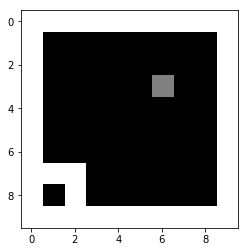

None

Rewards: [-201, -31, -29, -201, 13, -201, -201, 82, -201, -201, 12, 4, 98, -41, 69, -201, -201, -201, -201, -201, -201, -201, 6, -201, -201, -201, 16, -201, -39, 39, -25, -201, -3, -201, 23, -201, 47, -201, -41, -201, 4, 32, -30, 8, 15, -201, 24, -65, -201, -201]


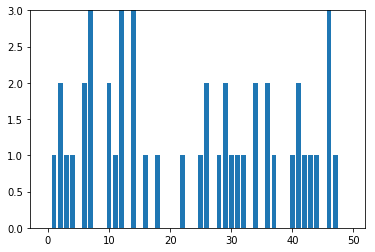

In [82]:
# 5. 10000 iterations; epsilon=0.1; Trained over pre-trained weights
agent.test(nb_episodes=50)

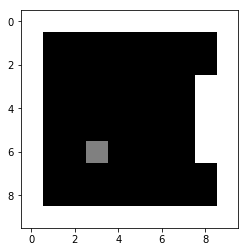

None

Rewards: [-201, -32, -201, -201, -201, -201, -201, -201, -201, -201, -16, -201, -201, -201, -7, -25, 5, -44, -201, 1, -32, -201, -9, -201, -5, -201, -201, -201, -201, -201, -201, -201, -201, -201, -201, -201, -201, -14, -201, -201]


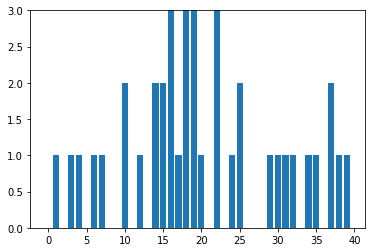

In [78]:
# 4. 5000 iterations; epsilon=0.1
agent.test(nb_episodes=40)

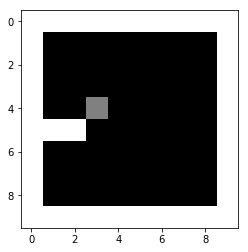

None

Rewards: [-13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, 3, -13, -13, -13, 3, -13, -13, -13, -13, -13, -13, -13, -13, 3, -13, -13, -13]


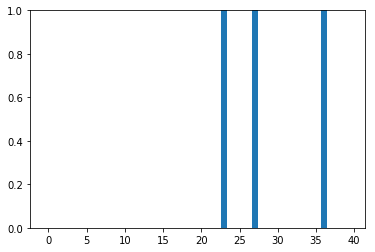

In [75]:
# 3. 5000 iterations; epsilon=0.1; No random action
agent.test(nb_episodes=40)

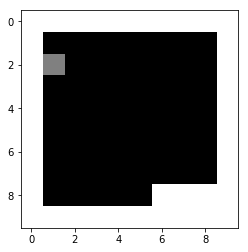

None

Rewards: [-14, -201, -15, -33, -201, -23, -32, -201, -27, -3, -30, -201, -15, -46, -12, -201, 9, -201, -13, -201, -201, -28, -201, -201, -14, -201, -61, -6, -201, -201, -16, -201, -201, -5, -201, -201, -201, -201, -201, -201]


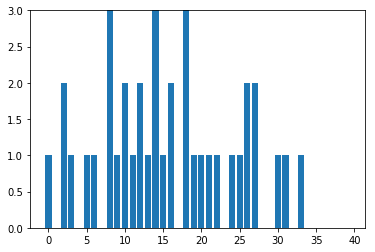

In [69]:
# 2. 5000 iterations; epsilon=0.5
agent.test(nb_episodes=40)

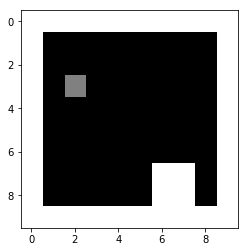

None

Rewards: [-251, -251, -46, -251, -251, -251, -63, -20, -251, -66, -251, -251, 1, -33, -251, 7, -251, -251, 0, -251, -44, -73, -1, -251, 10, -251, 10, -42, -18, -251, -251, -44, -251, -57, -251, -251, -251, 128, -251, -1, -251, -251, -251, -7, 4, -251, -251, -31, 2, -63, -251, -251, -20, -251, -37, -251, -251, 40, -43, -31, -251, -251, -40, -251, 21, 8, 5, -251, -251, -251, -10, -251, -251, -251, -23, -251, -251, -251, -4, -13, -251, -251, -9, 102, -251, -251, -251, -16, -251, -59, -67, -251, 1, -26, -251, -41, 2, -251, 21, 12]


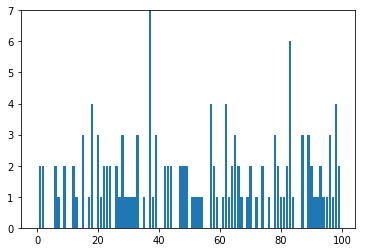

In [62]:
# 1. 30000 iterations; epsilon=0.3
agent.test(nb_episodes=100)

Possible problems:
* Model (Training parameters)
* Rewards
* Training iterations
* Randomness (epsilon)

Common Observations:
* Most episodes have a fixed set of moves running in an loop
* If the snake keeps growing well, it usually bumps into itself
* Very good at avoiding walls, but avoids food as well

# References

* [Basic Reinforcement Learning by Víctor Mayoral Vilches](https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial6/examples/Snake/snake.py)

* [Interactive Python Notebook for RL in Catch](https://gist.github.com/cadurosar/bd54c723c1d6335a43c8)